Let us consider a system of $N$ agents, each agent $i$
characterized by a dynamic opinion variable $x_i(t)$. For
the sake of simplicity, we consider opinions to be one dimensional,
with $x_i \in [-\infty;+\infty]$. The sign of the opinion
$x_i$, $\sigma(x_i)$, describes the agent's qualitative stance towards
 a binary issue of choice, such as the preference
between two candidates or a pro/con attitude in a controversial
topic. The absolute value of $x_i$, $|x_i|$, describes
the opinion's strength, or conviction, with respect to one
of the sides: the larger $|x_i|$, the more extreme the opinion
of agent $i$.

## Imports and settings

In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from matplotlib.ticker import MaxNLocator

from opdynamics.utils.distributions import negpowerlaw
from opdynamics.simulation import Simulation
from opdynamics.echochamber import EchoChamber, NoisyEchoChamber, logger as eclogger
from opdynamics.visualise import VisEchoChamber, show_K_alpha_phase

np.random.seed(1337)
sns.set_context("notebook")
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.INFO)

C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Example usage

## Parameters

In [2]:
num_agents = 1000
m = 10  # number of other agents to interact with
alpha = 3  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
epsilon = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 3  # power law decay of connection probability
r = 0.5 # probability of a mutual interaction
activity_distribution = negpowerlaw

## Create EchoChamber

In [3]:
ec = EchoChamber(num_agents, m, K, alpha)
vis = VisEchoChamber(ec)

## Set activity based on powerlaw distribution

$$ F(a) = \frac{1 - γ}{1 - ε^{1 - γ}} a^{-\gamma} \tag{1}$$

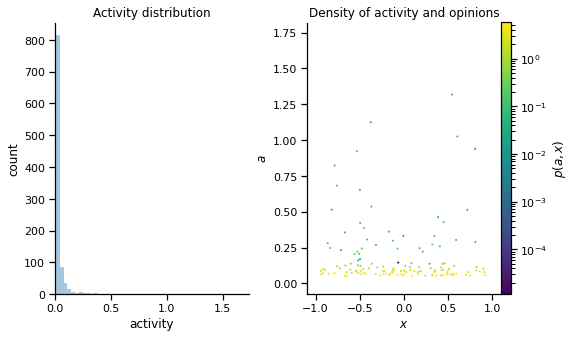

In [4]:
ec.set_activities(activity_distribution, gamma, epsilon, 2)
fig, ax = plt.subplots(1,2, figsize=(8,5))
fig.subplots_adjust(wspace=0.3)
vis.show_activities(ax=ax[0])
vis.show_activity_vs_opinions(ax=ax[1])
sns.despine()

## Connection probabilities

$$ p_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{2}$$

In [5]:
ec.set_connection_probabilities(beta=beta)

## Social Interactions
- adjacency matrix $A_{ij}(t)$ can be calculated before numerical integration (`lazy=False`) or at time $t$ (`lazy=True`).
- Cumulative adjacency matrix $\sum_{t=0}^T A_{ij}(t)$ can be plotted a number of ways using `vis.show_adjacency_matrix(...)`
    - `clustermap`
    - `heatmap`
    - `mesh`
    
    Interactions can be sorted using `sort=True` for plotting to identify clusters

DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 101 adjacency matrices...
101it [00:01, 55.59it/s]
DEBUG:social interaction:adjacency matrix has shape = (101, 1000, 1000)


(<seaborn.matrix.ClusterGrid at 0x27c34be0a48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27c34b939c8>)

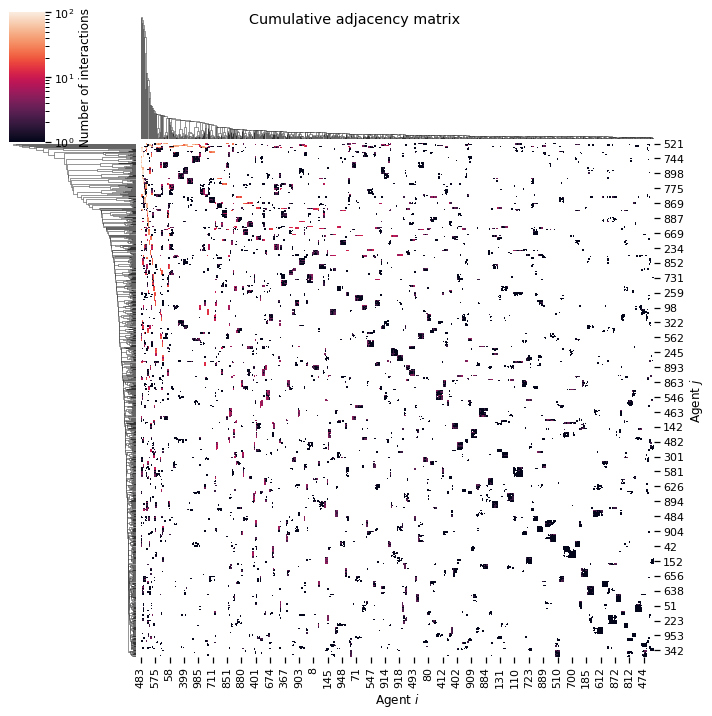

In [15]:
ec.set_social_interactions(0.5, lazy=False, t_end=1, dt=0.01)
vis.show_adjacency_matrix()
# keep a border around the main axis
sns.despine(top=False, right=False)

## Dynamics


Assuming that the opinion dynamics is solely
driven by the interactions among agents, we formulate
the model as $N$ coupled ordinary differential equations,

$$ \dot{x_i} = -x_i + K \sum_{j=1}^{N} A_{ij}(t) \tanh(\alpha x_j) \tag{3}$$

where K > 0 denotes the social interaction strength
among agents and $\alpha$ determines the sigmoidal shape of
the hyperbolic tangent. The opinion of an agent $i$ follows
the aggregated social input from the set of his/her neighbors
at time $t$, determined by the symmetric adjacency
matrix of the temporal network $A_{ij}(t)$, where $A_{ij}(t) = 1$
if agents $i$ and $j$ are interacting at time $t$, $A_{ij}(t) = 0$
otherwise. A similar model with static connectivity has
previously been used to describe the dynamics of neural
networks showing a transition from stationary to chaotic
phase [30].
The parameter $\alpha > 0$ tunes the degree of non-linearity
between an agent's opinion and the social influence s/he exerts on others.

In [16]:
ec.set_dynamics()

## Run and plot results

In [17]:
ec.run_network(dt=0.01, t_end=0.5, method='Euler')

INFO:solvers:solving ODE using Euler
51it [00:00, 112.33it/s]
DEBUG:echo chamber:done running echochamber


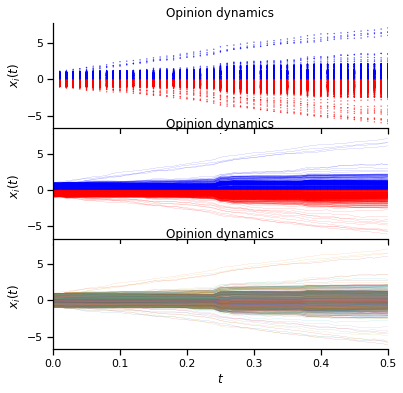

In [18]:
# some options on how to plot
fig, ax = plt.subplots(nrows=3, sharex='col', sharey='col', figsize=(6,6))
fig.subplots_adjust(hspace=0.05)
vis.show_opinions(color_code=True, ax=ax[0])    # markers
vis.show_opinions(color_code='line', ax=ax[1])  # lines (slowest)
vis.show_opinions(color_code=False, ax=ax[2])   # agents uniquely coloured
sns.despine(fig)

# Example results

> The convenient `Simulation.run_params` static method is used.

In [19]:
# General params

N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
r=0.5 # probability of mutual interaction
dt=0.01

# Specific params for different dynamics
param_set={
    "neutral": dict(K=3,alpha=0.05,beta=2),
    "radical": dict(K=3,alpha=3,beta=0),
    "polar": dict(K=3,alpha=3,beta=3)
    }

## Neutral opinion

- $K = 3$
- $\alpha = 0.05$
- $beta = 2$

DEBUG:simulation:run_params for <class 'type'> with (N=1000, m=10, K=3, alpha=0.05, beta=2, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=False)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 1001 adjacency matrices...
1001it [00:16, 58.92it/s]
DEBUG:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
DEBUG:echo chamber:done running echochamber
DEBUG:simulation:plotting


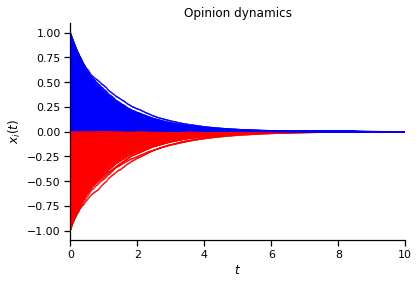

In [20]:
ec_neutral = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['neutral'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                   dt=0.01, T=T, r=r,
                                   plot_opinion=True)
sns.despine()

## Radicalisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 0$

DEBUG:simulation:run_params for <class 'type'> with (N=1000, m=10, K=3, alpha=3, beta=0, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=False)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 1001 adjacency matrices...
1001it [00:11, 85.15it/s]
DEBUG:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
DEBUG:echo chamber:done running echochamber
DEBUG:simulation:plotting


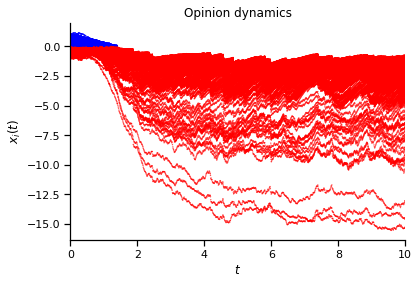

In [21]:
ec_radical = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['radical'],
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                   dt=0.01, T=T, r=r,
                                   plot_opinion=True)
sns.despine()

## Polarisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 3$

DEBUG:simulation:run_params for <class 'type'> with (N=1000, m=10, K=3, alpha=3, beta=3, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.5, plot_opinion=True, lazy=False)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.5.
INFO:social interaction:eagerly computing 1001 adjacency matrices...
1001it [00:17, 55.83it/s]
DEBUG:social interaction:adjacency matrix has shape = (1001, 1000, 1000)
DEBUG:echo chamber:done running echochamber
DEBUG:simulation:plotting


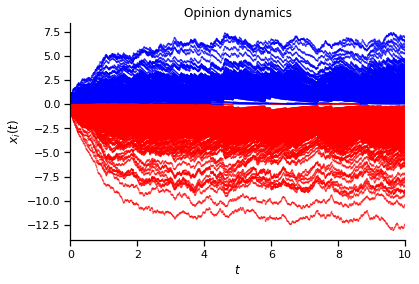

In [22]:
ec_polar = Simulation.run_params(EchoChamber, N=N, m=m, **param_set['polar'],
                                 activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                 dt=0.01, T=T, r=r,
                                 plot_opinion=True)
sns.despine()

## Compare opinons

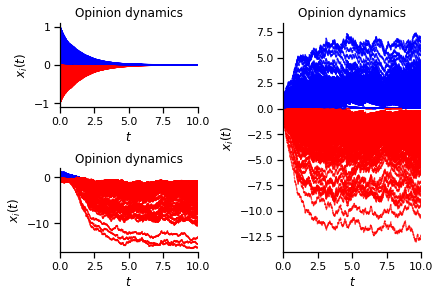

In [23]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig)
f_ax1 = fig.add_subplot(spec[0, 0]) # top left
f_ax2 = fig.add_subplot(spec[1, 0]) # bottom left
f_ax3 = fig.add_subplot(spec[:, 1]) # right column

VisEchoChamber(ec_neutral).show_opinions(ax=f_ax1)
VisEchoChamber(ec_radical).show_opinions(ax=f_ax2)
VisEchoChamber(ec_polar).show_opinions(ax=f_ax3)
sns.despine()

# Plot types

## $K-\alpha$ phase space

- $K \in [0,4]$
- $\alpha \in [0,4]$

with
- $beta = 0.5$
- $r = 0.5$


In [24]:
import os
import gc
import tqdm
beta = 0.5
r = 0.5

K_range = np.linspace(0,4,8)
alpha_range = np.linspace(0,4,8)
eclogger.setLevel(logging.DEBUG)

file_name = "K-alpha-phase.h5"
if os.path.exists(file_name):
    df = pd.read_hdf(file_name)
else:
    df = pd.DataFrame(index=K_range, columns=alpha_range, dtype=float)
    for K,alpha in tqdm(itertools.product(K_range,alpha_range)):
        ec = Simulation.run_params(EchoChamber,N=N, m=m, K=K, alpha=alpha, beta=beta, 
                                   activity=activity_distribution, epsilon=epsilon, gamma=gamma,
                                   dt=dt, T=T, r=r,
                                   lazy=True, plot_opinion=True)
        t, mu = ec.get_mean_opinion(-1)
        df.loc[K, alpha] = mu
        # clear some memory
        del ec
        gc.collect()
    df.to_hdf(file_name, key='df')


C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27c35d5d288>)

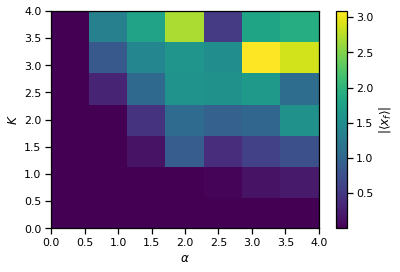

In [25]:
show_K_alpha_phase(df)

## Activity vs Opinion

- $K = 2$
- $\alpha = 3$
- $\beta = 1$
- $r = 0.65$

In [79]:
N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
dt=0.01
K=2
beta=1
alpha=3
r=0.65
ec = Simulation.run_params(EchoChamber,N,m,K,alpha,beta,activity_distribution,epsilon,gamma,dt,T,r,lazy=True)
vis = VisEchoChamber(ec)

DEBUG:simulation:run_params for EchoChamber with (N=1000, m=10, K=2, alpha=3, beta=1, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.01, T=10, r=0.65, plot_opinion=False, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={}
DEBUG:social interaction:Social Interaction for echochamber initialised with r=0.65.
DEBUG:echo chamber:done running echochamber


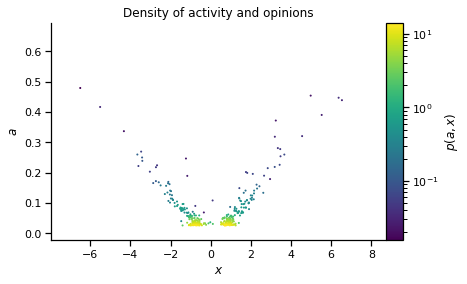

In [80]:
vis.show_activity_vs_opinions()
sns.despine()

## Show adjacency matrix

C:\Users\Chris\Anaconda3\envs\opinion_dynamics\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


(<Figure size 720x1440 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27f4a2f73c8>)

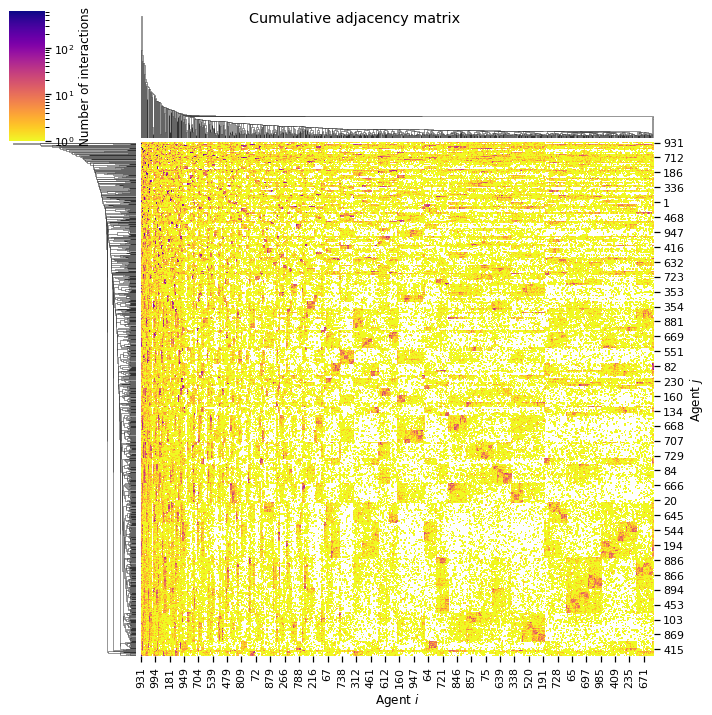

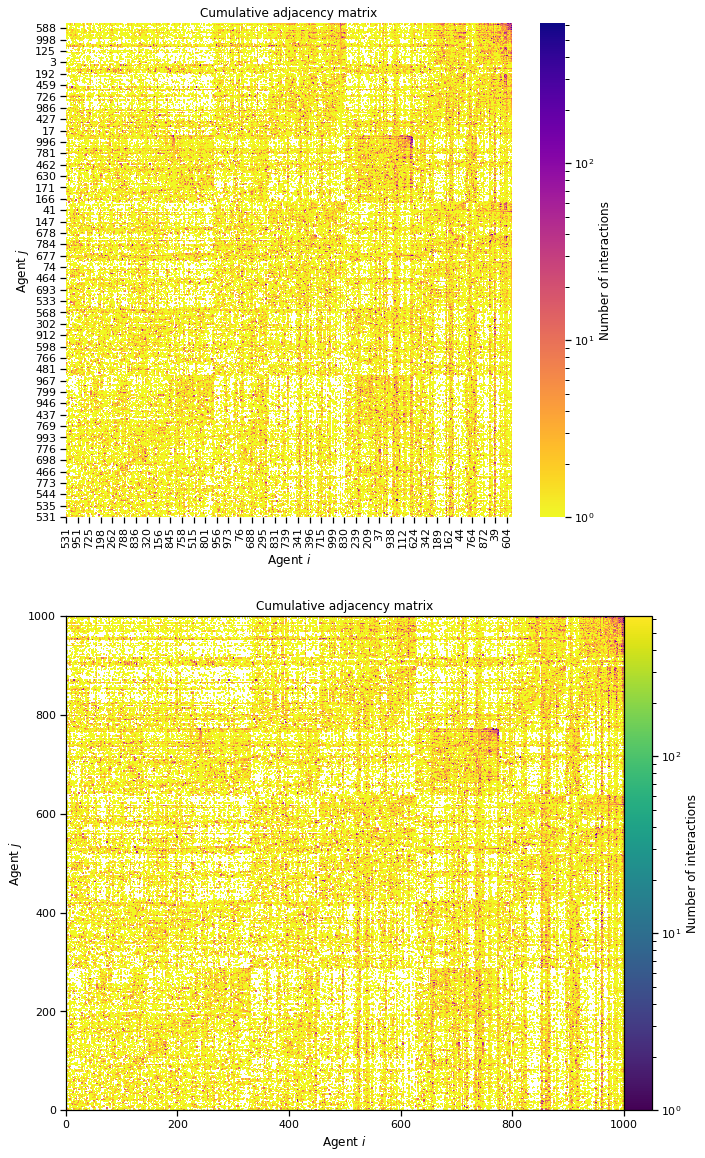

In [86]:
vis.show_adjacency_matrix("clustermap", ax=False, fig=False, sort=False, cmap='plasma_r')
fig, ax = plt.subplots(2, 1, figsize=(10,20))
vis.show_adjacency_matrix("heatmap", sort=True, ax=ax[0], cmap='plasma_r')
vis.show_adjacency_matrix("mesh", sort=True, ax=ax[1], cmap='plasma_r')


## Agent opinons at $t$

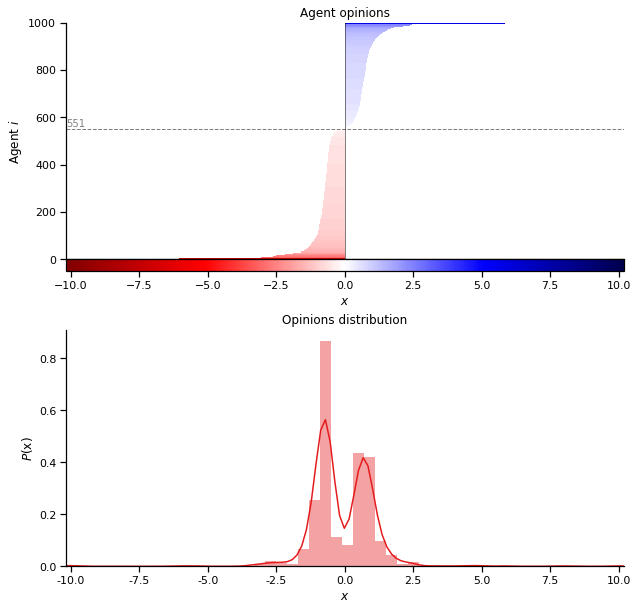

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.3)
vis.show_agent_opinions(direction=True, sort=True, ax=ax[0])
vis.show_opinions_snapshot(ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticks())
sns.despine()

## Nearest Neighbour

(-3.790644010323793, 4.363221830716399)

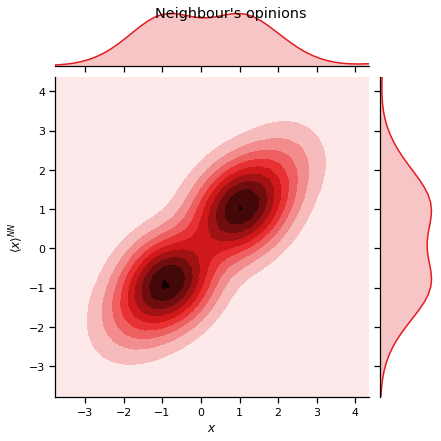

In [30]:
g = vis.show_nearest_neighbour()
# adjust limits based on xaxis
from scipy import stats
x_data, y_data = g.ax_marg_x.get_lines()[0].get_data()
s = stats.describe(y_data)
low_bound = np.max(s.mean-s.variance, 0)
mask = (low_bound < y_data)
lim = x_data[mask][0]*1.5, x_data[mask][-1]*1.5
g.ax_joint.set_xlim(*lim)
# keep it 'square' (xlim == ylim)
g.ax_joint.set_ylim(*lim)

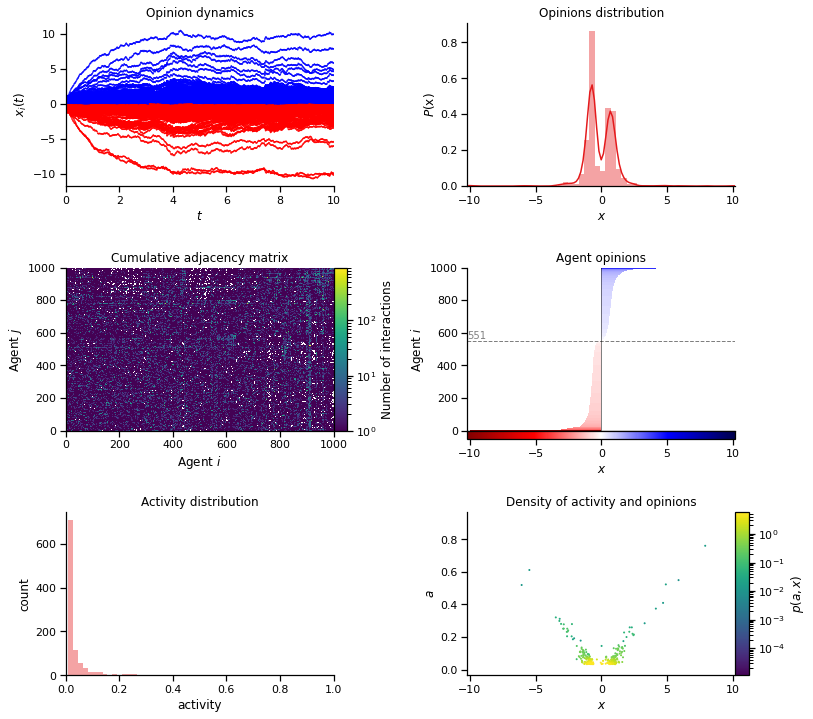

In [31]:
fig, ax = vis.show_summary(fig_kwargs=dict(figsize=(12,12), constrained_layout=False))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
sns.despine()

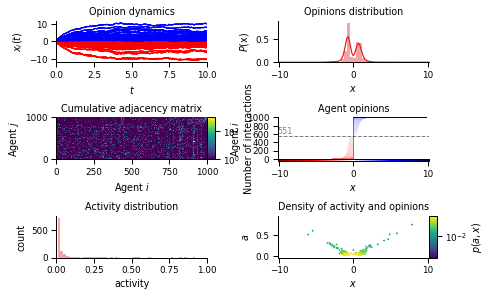

In [37]:
from matplotlib.cbook import flatten
with sns.plotting_context("notebook"):
    fig, ax = vis.show_summary(single_fig=True, fig_kwargs=dict(constrained_layout=True))
    for _ax in flatten(ax):
        sns.despine(ax=_ax)

# Noisy Echo Chamber

In [75]:
N=1000
m=10
T=10
epsilon=1e-2
gamma=2.1
dt=0.001
K=2
beta=1
alpha=3
r=0.65

D_range = [0, 0.01, 0.1, 1, 10]
vis_arr = []

for D in D_range:
    nec = Simulation.run_params(NoisyEchoChamber,
                                N,m,K,alpha,beta,activity_distribution,epsilon,gamma,dt,T,r,
                                D=D,lazy=True, method='Euler-Maruyama', 
                                name=f"D={D}")
    vis = VisEchoChamber(nec)
    vis_arr.append(vis)

DEBUG:simulation:run_params for NoisyEchoChamber with (N=1000, m=10, K=2, alpha=3, beta=1, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.001, T=10, r=0.65, plot_opinion=False, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={'D': 0, 'name': 'D=0'}
DEBUG:social interaction:Social Interaction for D=0 initialised with r=0.65.
INFO:solvers:solving SDE using Euler-Maruyama
10001it [06:10, 27.02it/s]
DEBUG:echo chamber:done running D=0
DEBUG:simulation:run_params for NoisyEchoChamber with (N=1000, m=10, K=2, alpha=3, beta=1, activity =<class 'opdynamics.utils.distributions.negpowerlaw'>(epsilon=0.01, gamma=2.1), dt=0.001, T=10, r=0.65, plot_opinion=False, lazy=True)
DEBUG:simulation:additional args=()	additional kwargs={'D': 0.01, 'name': 'D=0.01'}
DEBUG:social interaction:Social Interaction for D=0.01 initialised with r=0.65.
INFO:solvers:solving SDE using Euler-Maruyama
10001it [03:39, 45.49it/s]
DEBUG:echo chamber:done runni

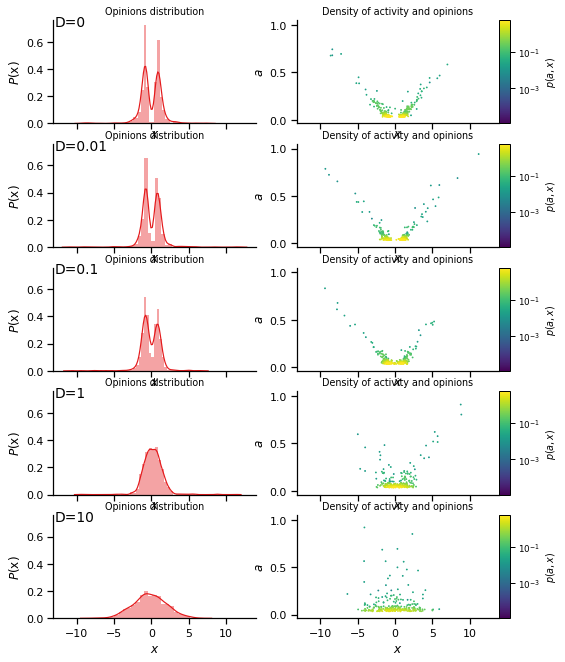

In [76]:
fig, ax = plt.subplots(nrows=len(D_range), ncols=2, sharex=True, sharey='col', figsize=(8, 11))

with sns.plotting_context("paper"):
    for i, (vis, _ax) in enumerate(zip(vis_arr, ax)):
        # 0 is first column, 1 is 2nd column
        vis.show_opinions_snapshot(ax=_ax[0])
        vis.show_activity_vs_opinions(ax=_ax[1])
        _ax[0].annotate(vis.ec.name, fontsize='x-large',
                        xy=(0.01, 1.05), xycoords='axes fraction', 
                        ha="left", va="top", rotation=0)
sns.despine()
plt.show()